# Projeto 2 de Ciência dos Dados 2022.1 
Integrantes: <br>
Alexandre Rodrigues Santarossa <br>
Gustavo Mendes da Silva
___

## Introdução:
O objetivo do nosso projeto foi prever o valor de um jogador de futebol da Premier League com base em suas principais estatísticas da temporada 2019/20.<br>
Para isso, tivemos que escolher e utilizar as melhores técnicas de classificação para atingir o melhor resultado possível. <br>

Base de dados utilizada: https://www.kaggle.com/datasets/kriegsmaschine/soccer-players-values-and-their-statistics
___

Carregando algumas bibliotecas e lendo os nossos arquivos em Excel:

In [2]:
# Bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy 
import os
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC 
from sklearn.metrics import classification_report,accuracy_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

import category_encoders as ce

In [3]:
# Leitura dos dados em Excel

df = pd.read_csv('dados.csv',sep=';',engine='python')

In [4]:
# Nossa base de dados

df

,Column1,player,nationality,position,squad,age,birth_year,value,height,position2,...,Pts/G,xG,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season
0,21,Martin Aguirregabiria,es ESP,DF,AlavĂ©s,23,1996,4000000,178,Defender - Right-Back,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
1,390,Oliver Burke,sco SCO,"MF,FW",AlavĂ©s,22,1997,4000000,188,Forward - Right Winger,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
2,430,VĂ­ctor Camarasa,es ESP,MF,AlavĂ©s,25,1994,4000000,183,Midfielder - Central Midfield,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
3,737,RubĂ©n Duarte,es ESP,DF,AlavĂ©s,23,1995,4000000,172,Defender - Left-Back,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
4,770,Rodrigo Ely,br BRA,DF,AlavĂ©s,25,1993,1000000,188,Defender - Centre-Back,...,1.03,37.0,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,1997,Daniel Podence,pt POR,"FW,MF",Wolves,23,1995,12000000,165,Forward - Right Winger,...,1.55,47.1,34.8,12.3,0.32,24758,0,0,NaN,201920#
2640,2202,Romain SaĂŻss,ma MAR,DF,Wolves,29,1990,4000000,188,Defender - Centre-Back,...,1.55,47.1,34.8,12.3,0.32,24758,0,0,NaN,201920#
2641,2523,Adama TraorĂ©,es ESP,"FW,MF",Wolves,23,1996,25000000,178,Forward - Right Winger,...,1.55,47.1,34.8,12.3,0.32,24758,0,0,NaN,201920#
2642,2567,JesĂşs Vallejo,es ESP,DF,Wolves,22,1997,6000000,184,Defender - Centre-Back,...,1.55,47.1,34.8,12.3,0.32,24758,0,0,NaN,201920#


Analisando os nossos dados, vimos que possuíamos variáveis demais, onde muitas delas não faziam efeito algum no valor do jogador, portanto, decidimos escolher apenas as principais variáveis do nosso banco de dados para obtermos resultados mais precisos em nossas previsões. <br>

Além disso, o nosso número de jogadores e clubes também era bastante elavado, assim, fizemos o nosso projeto com base apenas em jogadores de clubes atuantes na Premier League.

In [5]:
# Criando uma nova base de dados com apenas jogadores da Premier League e as suas principais variáveis 

liga = df['league'] == 'Premier League'
pl = df.loc[liga,['player','nationality','position','squad','age','value','minutes','goals','assists','tackles','clean_sheets',"saves",'passes_completed','gca','carries','Pts','CL','GDiff','W','L','D']]

In [6]:
# Nossa nova base de dados

pl

,player,nationality,position,squad,age,value,minutes,goals,assists,tackles,...,saves,passes_completed,gca,carries,Pts,CL,GDiff,W,L,D
79,Pierre-Emerick Aubameyang,ga GAB,FW,Arsenal,30,56000000,3136,22,3,39,...,0,612,10,865,56,0,8,14,10,14
80,HĂ©ctor BellerĂ­n,es ESP,DF,Arsenal,24,32000000,1158,1,0,23,...,0,558,0,489,56,0,8,14,10,14
81,Dani Ceballos,es ESP,MF,Arsenal,22,32000000,1692,0,2,49,...,0,1096,8,1083,56,0,8,14,10,14
82,Calum Chambers,eng ENG,DF,Arsenal,24,14000000,1102,1,1,25,...,0,702,3,681,56,0,8,14,10,14
83,MattĂ©o Guendouzi,fr FRA,MF,Arsenal,20,40000000,1748,0,1,24,...,0,1018,2,1042,56,0,8,14,10,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,Daniel Podence,pt POR,"FW,MF",Wolves,23,12000000,289,1,0,2,...,0,74,2,113,59,0,11,15,9,14
2640,Romain SaĂŻss,ma MAR,DF,Wolves,29,4000000,2705,2,1,66,...,0,1252,2,1058,59,0,11,15,9,14
2641,Adama TraorĂ©,es ESP,"FW,MF",Wolves,23,25000000,2605,4,9,6,...,0,399,15,1252,59,0,11,15,9,14
2642,JesĂşs Vallejo,es ESP,DF,Wolves,22,6000000,163,0,0,4,...,0,81,0,85,59,0,11,15,9,14


In [7]:
# Limpeza para remover os valores nulos dos nossos dados, eliminando as linhas ou colunas que contêm os valores 
# nulos, sendo eles NaN (Not a Number) ou NaT (Not a Time)

pl.dropna(inplace=True)

In [8]:
# Descrição dos nossos dados após a limpeza

pl.describe()

,age,value,minutes,goals,assists,tackles,clean_sheets,saves,passes_completed,gca,carries,Pts,CL,GDiff,W,L,D
count,511.000000,5.110000e+02,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,25.598826,1.554783e+07,1468.749511,1.958904,1.381605,26.279843,0.395303,4.043053,577.422701,3.211350,572.530333,51.825832,0.199609,-0.757339,14.199609,14.573386,9.227006
std,4.270914,1.925993e+07,1036.296935,3.613737,2.163234,24.984269,1.983337,18.645141,507.640503,4.464934,471.747189,17.314705,0.400098,27.550592,6.136621,5.587977,3.148503
min,16.000000,2.500000e+02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,-49.000000,5.000000,3.000000,3.000000
25%,22.000000,4.000000e+06,590.000000,0.000000,0.000000,6.000000,0.000000,0.000000,157.000000,0.000000,167.000000,39.000000,0.000000,-20.000000,9.000000,11.000000,7.000000
50%,26.000000,9.000000e+06,1344.000000,1.000000,1.000000,21.000000,0.000000,0.000000,466.000000,1.000000,486.000000,52.000000,0.000000,-9.000000,14.000000,15.000000,10.000000
75%,29.000000,2.000000e+07,2367.000000,2.000000,2.000000,41.000000,0.000000,0.000000,871.000000,5.000000,860.500000,59.000000,0.000000,14.000000,16.000000,19.000000,12.000000
max,37.000000,1.280000e+08,3420.000000,23.000000,20.000000,138.000000,16.000000,134.000000,2791.000000,34.000000,2321.000000,99.000000,1.000000,67.000000,32.000000,27.000000,14.000000


Para analisar os resultados da nossa limpeza de variáveis, fizemos um gráfico de calor para uma melhor visualização da correlação entre as nossas variáveis.

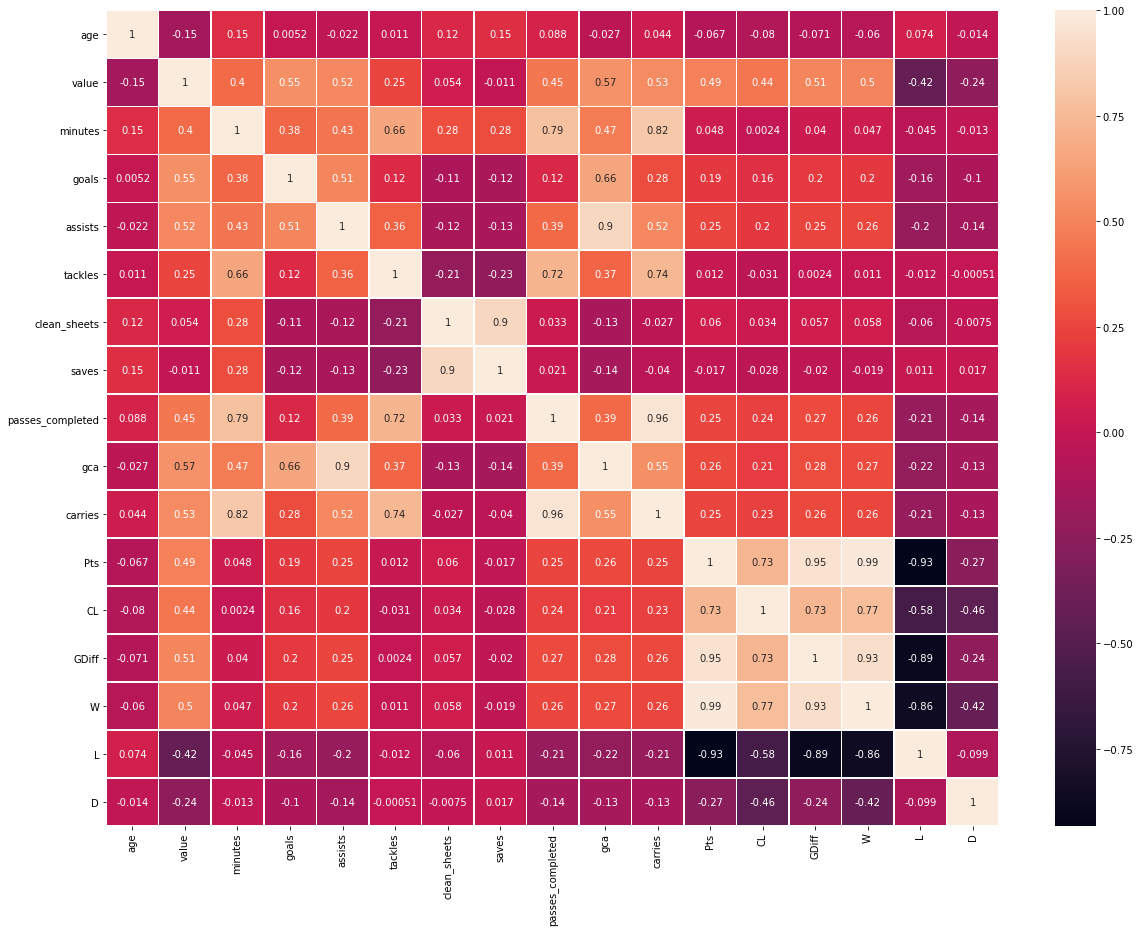

In [9]:
# O mapa de calor das nossas variáveis

fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(pl.corr(),ax=ax,annot=True,linewidth=.5);

Como todas as nossas variáveis possuem um bom valor de correlação entre elas, podemos seguir com os nossos modelos de previsão.<br>
Antes de iniciar qualquer modelo, devemos separar os nossos dados em dois dataframes diferemtes, um para o treino do nosso modelo, e um para testá-lo. Para isso, retiramos algumas variáveis desnecessárias

In [10]:
# Arrumando o dataframe e separando em train e test

X = pl.drop("value", axis=1)
X = X.drop("player", axis=1)
y = pl["value"]

encoder = ce.OneHotEncoder(use_cat_names=True)

X = encoder.fit_transform(X)    

Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.3, random_state=0)

## Modelo por Regressão Múltipla

A Regressão Linear Múltipla é um modelo de análise que usamos quando modelamos a relação linear entre uma variável de desfecho contínua e múltiplas variáveis preditoras que podem ser contínuas ou categóricas.

a fórmula da regressão nada mais é do que a equação que descreve uma reta:


Y = α+β$_1$.X1


Onde Y é a variável de interesse, a que queremos prever. X é nossa variável preditora e que está associado ao β, que dirá o quão inclinado está a reta, ou o quão influente é a variável preditora. Por sua vez, o α é o valor que descreve o intercepto: onde a linha está quando o valor de X é zero.

Na Regressão Linear Múltipla, a fórmula é bem parecida, só vamos acrescentar outras variáveis preditoras:

Y = α+β$_1$.X1 +β$_2$.X2


Na fórmula acima temos duas variáveis preditoras e seus betas. Dando continuidade a este modelo, podemos ter quantas variáveis preditoras quanto quisermos:

Y = α+β$_1$.X1 +β$_2$.X2 +β$_3$.X3+...+β$_n$.Xn



In [11]:
# Função utilitária para fazer a regressão com constante adicionada

def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [12]:
results = regress(ytr,Xtr)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     7.999
Date:                Tue, 07 Jun 2022   Prob (F-statistic):           7.84e-41
Time:                        22:39:41   Log-Likelihood:                -6254.2
No. Observations:                 357   AIC:                         1.270e+04
Df Residuals:                     261   BIC:                         1.307e+04
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2.454e+04   8146.272      3.013      0.003    8501.377    4.06e+04
nationality_ga GAB    -2.171e+06   1.25e+07     -0.173      0.863   -2.69e+07    2.25e+07
nationality_es ESP    -5.018e+06   2.88e+06     -1.744      0.082   -1.07e+07    6.47e+05
nationality_eng ENG   -1.841e+06    1.7e+06     -1.082      0.280   -5.19e+06    1.51e+06
nationality_fr FRA     2.376e+06   3.08e+06      0.772      0.441   -3.68e+06    8.43e+06
nationality_ba BIH    -1.658e+06   1.19e+07     -0.140      0.889    -2.5e+07    2.17e+07
nationality_de GER     5.872e+06   3.65e+06      1.608      0.109   -1.32e+06    1.31e+07
nationality_br BRA    -7.707e+06   3.47e+06     -2.223      0.027   -1.45e+07   -8.82e+05
nationality_ar ARG    -4.944e+06   3.88e+06     -1.273      0.204   -1.26e+07     2.7e+06
nationality_am ARM     1.755e+07    1.2e+07      1.464      0.144   -6.06e+06    4.11e+07
nationality_gr GRE    -9.594e+05   8.46e+06     -0.113      0.910   -1.76e+07    1.57e+07
nationality_ci CIV     9.245e+06   4.93e+06      1.873      0.062   -4.72e+05     1.9e+07
nationality_pt POR     5.123e+06    4.8e+06      1.068      0.286   -4.32e+06    1.46e+07
nationality_sco SCO   -5.666e+06   4.02e+06     -1.410      0.160   -1.36e+07    2.25e+06
nationality_uy URU     1.628e+07   1.19e+07      1.374      0.171   -7.06e+06    3.96e+07
nationality_ch SUI    -1.214e+06   5.42e+06     -0.224      0.823   -1.19e+07    9.47e+06
nationality_eg EGY    -6.334e+06   8.65e+06     -0.732      0.465   -2.34e+07    1.07e+07
nationality_be BEL     3.223e+06   4.11e+06      0.783      0.434   -4.88e+06    1.13e+07
nationality_nl NED    -1.442e+06    4.2e+06     -0.343      0.732   -9.72e+06    6.83e+06
nationality_ie IRL    -3.523e+06   3.14e+06     -1.123      0.262    -9.7e+06    2.66e+06
nationality_zw ZIM    -1.456e+06   1.18e+07     -0.123      0.902   -2.47e+07    2.18e+07
nationality_no NOR     2.028e+06   6.06e+06      0.335      0.738    -9.9e+06     1.4e+07
nationality_tz TAN     6.218e+06   1.19e+07      0.523      0.601   -1.72e+07    2.96e+07
nationality_wal WAL   -1.561e+06   4.77e+06     -0.327      0.744    -1.1e+07    7.84e+06
nationality_us USA     4.129e+06   8.44e+06      0.489      0.625   -1.25e+07    2.07e+07
nationality_dk DEN     3.458e+06   6.27e+06      0.552      0.582   -8.88e+06    1.58e+07
nationality_co COL     3.649e+06   7.03e+06      0.519      0.604   -1.02e+07    1.75e+07
nationality_ro ROU     1.257e+06   1.19e+07      0.105      0.916   -2.22e+07    2.48e+07
nationality_ml MLI     1.712e+06    8.6e+06      0.199      0.842   -1.52e+07    1.86e+07
nationality_cm CMR     9.691e+06    8.6e+06      1.127      0.261   -7.24e+06    2.66e+07
nationality_ir IRN     5.303e+06   1.19e+07      0.444      0.657   -1.82e+07    2.88e+07
nationality_au AUS    -

Aqui selecionamos nosso resultado de uma forma que o nosso p fique menor que 0.1 (P >|t| )

In [13]:
results = regress(ytr,Xtr)
p_valores = results.pvalues.sort_values(ascending=False)
tem_menor = True
X = Xtr.copy()
while tem_menor:
    if p_valores.index[0] == 'const':
        p_valores = p_valores[1:]
    if p_valores[0] > 0.1:
        X = X.drop(p_valores.index[0],axis=1)
        results = regress(ytr,X)
        p_valores = results.pvalues.sort_values(ascending=False)
    else:
        tem_menor = False
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     31.40
Date:                Tue, 07 Jun 2022   Prob (F-statistic):           1.38e-73
Time:                        22:39:42   Log-Likelihood:                -6275.4
No. Observations:                 357   AIC:                         1.260e+04
Df Residuals:                     330   BIC:                         1.271e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.804e+06   8.01e+06     -0.225      0.822   -1.76e+07     1.4e+07
nationality_es ESP    -5.436e+06   2.58e+06     -2.107      0.036   -1.05e+07    -3.6e+05
nationality_eng ENG   -2.971e+06   1.35e+06     -2.203      0.028   -5.62e+06   -3.18e+05
nationality_de GER     6.674e+06   3.25e+06      2.051      0.041    2.72e+05    1.31e+07
nationality_br BRA    -7.787e+06   3.17e+06     -2.456      0.015    -1.4e+07   -1.55e+06
nationality_ci CIV     8.425e+06   4.54e+06      1.857      0.064   -4.98e+05    1.73e+07
nationality_sco SCO   -6.572e+06   3.62e+06     -1.817      0.070   -1.37e+07    5.43e+05
nationality_sn SEN     1.089e+07    5.6e+06      1.944      0.053   -1.31e+05    2.19e+07
nationality_dz ALG     -1.37e+07   7.99e+06     -1.715      0.087   -2.94e+07    2.02e+06
nationality_ua UKR    -1.465e+07   7.87e+06     -1.862      0.063   -3.01e+07    8.24e+05
position_FW,MF        -4.098e+06   2.17e+06     -1.892      0.059   -8.36e+06    1.63e+05
squad_Everton          6.078e+06   2.72e+06      2.233      0.026    7.24e+05    1.14e+07
squad_Leicester City  -2.544e+07   4.67e+06     -5.444      0.000   -3.46e+07   -1.62e+07
squad_Manchester City -2.342e+07   6.85e+06     -3.419      0.001   -3.69e+07   -9.94e+06
squad_Newcastle Utd    1.044e+07   3.22e+06      3.241      0.001    4.11e+06    1.68e+07
squad_Southampton     -7.556e+06   2.73e+06     -2.763      0.006   -1.29e+07   -2.18e+06
squad_Watford          4.741e+06   2.86e+06      1.660      0.098   -8.78e+05    1.04e+07
age                   -8.629e+05   1.47e+05     -5.888      0.000   -1.15e+06   -5.75e+05
minutes               -7511.8236   1642.191     -4.574      0.000   -1.07e+04   -4281.340
goals                  2.355e+06   2.13e+05     11.042      0.000    1.94e+06    2.77e+06
assists                8.222e+05   3.46e+05      2.376      0.018    1.41e+05     1.5e+06
tackles                8.545e+04   4.36e+04      1.959      0.051    -362.960    1.71e+05
clean_sheets           2.507e+06   4.76e+05      5.262      0.000    1.57e+06    3.44e+06
carries                2.391e+04   3271.703      7.307      0.000    1.75e+04    3.03e+04
CL                    -9.086e+06   3.18e+06     -2.861      0.004   -1.53e+07   -2.84e+06
GDiff                  8.446e+05   1.53e+05      5.505      0.000    5.43e+05    1.15e+06
L                      2.318e+06   5.18e+05      4.477      0.000     1.3e+06    3.34e+06
==============================================================================
Omnibus:                      145.508   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1324.943
Skew:                           1.447   Prob(JB):                    1.96e-288
Kurtosis:                      11.983   Cond. No.                  

In [17]:
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import norm, probplot
durbin_watson(results.resid)

1.9407084274296462

((array([-2.88780441, -2.59656375, -2.43207346, -2.31506855, -2.22314981,
         -2.14688775, -2.08138437, -2.02375606, -1.97215622, -1.92532834,
         -1.88237724, -1.84264176, -1.80561913, -1.77091781, -1.73822662,
         -1.70729407, -1.6779138 , -1.64991439, -1.62315177, -1.59750365,
         -1.57286533, -1.54914644, -1.52626837, -1.50416238, -1.48276793,
         -1.46203143, -1.44190521, -1.42234667, -1.40331759, -1.38478351,
         -1.36671328, -1.34907863, -1.33185381, -1.31501533, -1.29854166,
         -1.28241305, -1.26661131, -1.25111965, -1.23592257, -1.22100569,
         -1.20635567, -1.19196007, -1.17780734, -1.16388668, -1.15018797,
         -1.13670177, -1.12341921, -1.11033194, -1.09743213, -1.0847124 ,
         -1.07216579, -1.05978573, -1.047566  , -1.03550072, -1.02358433,
         -1.01181155, -1.00017735, -0.98867699, -0.97730592, -0.96605983,
         -0.95493462, -0.94392636, -0.93303132, -0.92224591, -0.91156674,
         -0.90099053, -0.89051415, -0.

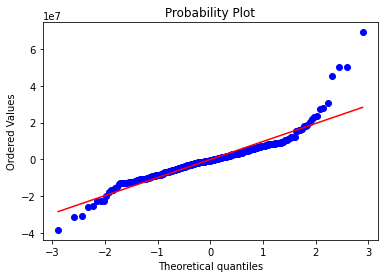

In [18]:
plt.figure()
probplot(results.resid, dist = 'norm', plot = plt)

## Modelo por Árvore de Decisão / Regressão

Uma Árvore de Decisão funciona como uma espécie de mapa de todos os resultados possíveis gerados por uma série de escolhas relacionadas, fazendo alusão a uma árvore e aos seus galhos e folhas, onde se começa com um único nó, que se divide em possíveis resultados. Cada escolha feita pelo modelo leva a outros nós, que se dividem em mais possibilidades. 

De forma geral, podemos dizer que as árvores de decisão têm a vantagem devido ao seu fácil entendimento, além de ser interpretável em todos os seus níveis, o que a torna muito útil. 

<img src= img/arvore.png>

In [14]:
# Modelo de Decision Tree Regressor

arvore = DecisionTreeRegressor(random_state=0)
arvore.fit(Xtr,ytr)

p = arvore.predict(Xval)

print("O nosso modelo de Árvore de Decisão tem um erro de €{:.0f} comparado com o valor correto e uma taxa de acerto de {:.2f}%".format(np.sqrt(mean_squared_error(yval, p)),arvore.score(Xval, yval)*100))

O nosso modelo de Árvore de Decisão tem um erro de €14789956 comparado com o valor correto e uma taxa de acerto de 38.26%


# Modelo por Floresta Aleatória / Regressão

Este modelo chamado de Floresta Aleatória porque envolve inúmeros modelos de Árvores de Decisão que explicamos acima, onde os dados dessas árvores são misturados para garantir resultados mais precisos, deste modo, enquanto uma Árvore de Decisão sozinha tem um resultado e uma gama estreita de grupos, a floresta garante um resultado mais preciso, com um número maior de grupos e decisões, trazendo aleatoriedade ao nosso modelo, aonde é encontrado o melhor subconjunto de recursos.

<img src = img/floresta.png>

In [15]:
# Modelo de Random Forest Regressor

floresta = RandomForestRegressor(random_state=0)
floresta.fit(Xtr,ytr)

p = floresta.predict(Xval)

print("O nosso modelo de Floresta Aleatória tem um erro de €{:.0f} comparado com o valor correto e uma taxa de acerto de {:.2f}%".format(np.sqrt(mean_squared_error(yval, p)),floresta.score(Xval, yval)*100))

O nosso modelo de Floresta Aleatória tem um erro de €11583189 comparado com o valor correto e uma taxa de acerto de 62.13%


## Conclusão

O valor de um jogador de futebol baseado em suas estatísticas possui uma correlação importante, entretanto, nada que envolve o esporte mais famoso do mundo pode ser relacionado apenas com números e estatísticas, tudo acaba sendo incerto, onde os fatores externos devem ser considerados. Um exemplo disso é a popularidade do jogador sendo ela relacionada com a personalidade e o conteúdo produzido em suas redes sociais, tais fatores externos são impossiveis de serem calculados com os metodos que testamos aqui no projeto, de modo que a nossa previsão não conseguiu se aproximar tanto da realidade.
Levando em conta tudo isso, com base nos três modelos que fizemos, sendo eles, a Regressão Múltipla, a Árvore de Decisão e a Floresta Aleatória, o modelo que imita uma floresta de inúmeras árvores de decisões foi o que apresentou o melhor resultado, já que é o modelo mais completo dos modelos testados e também porque conta com o fator da aleatoriedade que o modelo de Árvore de Decisão não possui, dando a ele um grande diferencial e um aumento de mais 20% de precisão, terminando o nosso projeto com 62.13% de acurácia no valor de um jogador de futebol qualquer que atua na Premier League.